# <a id="top">Link Prediction: Predicting Author Collaborations with Neo4j, Spark MLlib and Node2Vec</a>


Ana Areias, August 2020





This work started out as an exercise in working through the link prediction example in the book "Graph Algorithms. Practical Examples in Apache Spark and Neo4j".   

Using [a author collaboration network](#the-citation-data) I compare a series of [Random Forest (RF)](#rf) binary classifiers to predict whether two author nodes will collaborate in the future. Several neighborhood [features are built in order to characterize the relationship between nodes](#graphy) and their ability to predict future links [compared.](#model-comparison)

One [train-test split of the data](#split-train-test) is used to estimate classifier performance. The models are trained on author collaborations before the year 2006 and tested against collaborations in 2006 and after. 

An important characteristic of the co-author dataset is it's unbalanced nature. Negative links (the absence of a co-author relationship between two nodes) are much more numerous than positive links which can make it difficult for a classifier to learn to identify positive examples. One solution is to [down-sample negative links.](#balancing)  

I extend the example to use [Node2Vec embeddings](#node2vec) as a feature in the classifier. The choice of Node2Vec parameters ends up being an important determinant of classifer performance so I tune [the choice of binary operator to represent edges](#epx1), [random walk In-Out and return parameters](#exp2) and [walk length, number of walks and resulting dimension size of embedding vector](#exp3) instead of relying on their default values. Of all the parameters the choice of In-Out, return and binary operator parameters are most crucial.  

[The best node2vec embeddings RF classifier loses out to one consisting of neighborhood, graphy and community features](#comparison2), at least in this case the manual feature engineering approach was victorious.  

Another way I modified this example is to use a [cross-validation pipeline](#custom-cv) allowing me to run all models at once on the train and test sets, instead of separately. Spark currently only supports random partition into train and test sets so I use a custom cross-validator that lets me define which observations are in the train and test set. 

The cross-validator pipeline is also a step in the direction of using several train/test splits and rounds of cross-validation rather than just one, better capturing the variability in performance metrics. However I leave  this for the next iteration since all graphy features would have to be re-calculated separately for each fold in order to avoid data leakage.

1. [The citation data](#the-citation-data)
2. [Neo4j Docker container](#neo4j-docker-container)
3. [Loading the data into Neo4j](#co-authorship-graph)
4. [Splitting into train and test samples](#split-train-test)
5. [Downsampling negative edges](#balancing)
6. [Graphy features](#graphy) 
7. [Random Forest classifier in Spark](#rf)
8. [Custom cross-validation folds](#custom-cv)
9. [Model comparison](#model-comparison)
10. [Node2Vec graph embeddings](#node2vec)
11. [More model comparison](#comparison2)
12. [Conclusion and future steps](#conclusions)
13. [References](#references)

## <a id="the-citation-data">1. The Citation Data</a>


Data comes from DBLP-Citation-network V10 at https://www.aminer.org/citation. In each text file, each line represents a paper, which is in JSON schema. DBLP-Citation-network V10 consists of 3,079,007 papers and 25,166,994 citation relationships. For local development I take a sample of the first 15,000 lines.


[Back to top](#top)

In [1]:
import json
import os

# making smaller sample data
file = open("data/dblp-ref/dblp-ref-3.json", "r")
smallfile = open("import/dblp-ref-3-small.json", "a")

for i in range(15000):
    line=file.readline()
    smallfile.write(line)
    
file.close()
smallfile.close()

# example observation
print(json.dumps(json.loads(line), indent=4, sort_keys=True))

{
    "authors": [
        "Macario O. Cordel",
        "Arnulfo P. Azcarraga"
    ],
    "id": "fff8aa8d-19eb-4cdb-b45c-d93ab48f32bc",
    "n_citation": 0,
    "references": [
        "526860a6-aea8-4f8d-b7f9-e01d3629a6a9",
        "b3021ed3-42de-4b75-ad6e-bd64e51f4cba"
    ],
    "title": "Measuring the contribution of filter bank layer to performance of convolutional neural networks",
    "venue": "International Journal of Knowledge-based and Intelligent Engineering Systems",
    "year": 2017
}


## <a id="neo4j-docker-container">2. Neo4j Docker Container</a>

Neo4j provides an [official Docker image](https://neo4j.com/docs/operations-manual/current/docker/introduction/). I use a bash script start-neo4j-container.sh to start and configure the container, installing  Neo4j Labs plugins APOC and Graph Data Science. You can find the script in the project repository.


[Back to top](#top)

## <a id="co-authorship-graph">3. Loading the Data into Neo4j to Create the Co-authorship Graph</a>

I load the json data using an APOC routine and run cypher queries to create the graph and return some summary statistics.

Neo4j cypher queries for creating co-authorship graph, data balancing and graphy features are from book chapter "Graphs and Machine Learning in Practice: Link Prediction" in *Graph Algorithms. Practical Examples in Apache Spark and Neo4j.*



[Back to top](#top)

In [2]:
# Connect to the neo4j docker instance
from py2neo import  Graph, Node
graphdb = Graph(scheme="bolt", host="localhost", port=7687, secure=False, auth=('neo4j', 'test'))
graphdb.delete_all()

In [131]:
# Create data constraints to ensure no duplicate authors or papers
#graphdb.run("""CREATE CONSTRAINT ON (a:Article)
#    ASSERT a.index IS UNIQUE""")

#graphdb.run("""CREATE CONSTRAINT ON (au:Author)
#    ASSERT au.name IS UNIQUE;""")


In [3]:
# Load json subset of data, filter on journal title, creates author and paper nodes, create author of 
# paper relationship
graphdb.run("""CALL apoc.load.json("file:///dblp-ref-3-small.json")
    YIELD value
    WHERE value.venue IN ["Lecture Notes in Computer Science",
        "Communications of The ACM",
        "international conference on software engineering",
        "advances in computing and communications"]
    MERGE (p:Article {title: value.title})
    SET p.year = value.year
    WITH p, value
    UNWIND value.authors AS author
    MERGE (c:Author {name: author})
    MERGE (p)-[:AUTHOR_OF]->(c)
    """)

In [4]:
# Create co-author collaborations setting edge properties year of first collaboration and total number 
# of collaborations 
# Note: Pointing authors to papers results in double-counting co-authorships
graphdb.run("""MATCH (a1:Author)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
    WITH a1,a2, paper
    ORDER BY a1,paper.year
    WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
    MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
    SET coauthor.collaborations = collaborations;
    """)

In [5]:
# Some summary statistics of graph
print(str(graphdb.run("""MATCH (n) RETURN count(n)""").evaluate()) + " nodes")
print(str(graphdb.run("""MATCH (n:Article) RETURN count(n)""").evaluate()) + " articles")
print(str(graphdb.run("""MATCH (n:Author) RETURN count(n)""").evaluate()) + " authors")
print(str(graphdb.run("""MATCH ()-[r]->() RETURN count(*)""").evaluate()) + " relationships")

5676 nodes
1579 articles
4097 authors
10210 relationships


In [6]:
# Types of nodes
graphdb.run("""MATCH (n) RETURN labels(n) AS NodeType, count(n) AS NumberOfNodes""").to_table()

NodeType,NumberOfNodes
['Author'],4097
['Article'],1579


In [7]:
# Types of relationships (edges)
graphdb.run("""MATCH  ()-[r]-()
    RETURN type(r) AS RelationshipType, count(r) AS NumberOfRelationships""").to_table()

RelationshipType,NumberOfRelationships
CO_AUTHOR,11286
AUTHOR_OF,9134


In [8]:
# Edge properties
graphdb.run("""MATCH (u:Article) RETURN keys(u) LIMIT 1""").to_table()

keys(u)
"['title', 'year']"


In [9]:
graphdb.run("""MATCH ()-[t:AUTHOR_OF]-() RETURN keys(t) LIMIT 1""").to_table()

keys(t)
[]


In [10]:
graphdb.run("""MATCH ()-[t:CO_AUTHOR]-() RETURN keys(t) LIMIT 1""").to_table()

keys(t)
"['collaborations', 'year']"


In [11]:
# Collaboration statistics
graphdb.run("""MATCH ()-[p:CO_AUTHOR]-()
    RETURN min(p.collaborations) AS MinCollaborations, 
    max(p.collaborations) AS MaxCollaborations, 
    avg(p.collaborations) AS AvgCollaborations, 
    stDev(p.collaborations) AS StdCollaborations
    """).to_table()

MinCollaborations,MaxCollaborations,AvgCollaborations,StdCollaborations
1,6,1.0241006556796042,0.18481201975399397


In [12]:
# More collaboration statistics
graphdb.run("""MATCH ()-[p:CO_AUTHOR]-()
    RETURN p.collaborations, count(p.collaborations) AS total
    ORDER BY p.collaborations""").to_table()

p.collaborations,total
1,11050
2,214
3,16
5,4
6,2


## <a id="split-train-test">4. Splitting the data into training and test sets </a>


In order to evaluate our link prediction algorithms I split the data into a train and a test set. Looking at the year of publication shows that most articles in the dataset were published in the years leading up to 2006. So we can use collaborations before 2006 as the training set and those in 2006 and after as the test set. 

Splitting on year of publication ensures there is no data leakage between training and test datasets, since  ignoring this dimension means that the training set in our experiment would have information about future collaborations that it wouldn't have access to in reality and our estimate of out-sample classifier performance would be too optimistic.

Two new types of relationships are created, CO_AUTHOR_EARLY for pairs of authors whose first collaboration precedes 2006 and CO_AUTHOR_LATE for pairs of authors whose **first** collaboration is in 2006 or beyond.



[Back to top](#top)



In [13]:
import matplotlib.pyplot as plt  
%matplotlib inline

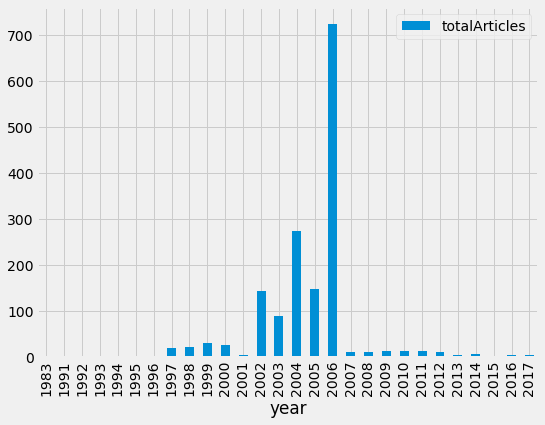

In [14]:
articles=graphdb.run("""MATCH (a:Article)
    RETURN a.year AS year, count(a.year) AS totalArticles
    ORDER BY year""").to_data_frame()
    
plt.style.use('fivethirtyeight')
articles.plot("year","totalArticles", kind="bar",figsize=(8, 6))
plt.show()

In [15]:
graphdb.run("""MATCH (a:Article)
    RETURN a.year < 2006 AS training, count(*) AS count""").to_table()

training,count
false,817
true,762


In [16]:
# Create relationship CO_AUTHOR_EARLY for co-author pairs whose first collaboration ocurred before 2006
graphdb.run("""MATCH (a1)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
    WHERE year < 2006
    MERGE (a1)-[coauthor:CO_AUTHOR_EARLY {year: year}]-(a2)
    SET coauthor.collaborations = collaborations""")

In [17]:
# Create relationship CO_AUTHOR_LATE for co author pairs whose first collaboration ocurred during or after 2006
graphdb.run("""MATCH (a1)<-[:AUTHOR_OF]-(paper:Article)-[:AUTHOR_OF]->(a2:Author)
    WITH a1, a2, paper
    ORDER BY a1, paper.year
    WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
    WHERE year >= 2006
    MERGE (a1)-[coauthor:CO_AUTHOR_LATE {year: year}]-(a2)
    SET coauthor.collaborations = collaborations""")

In [18]:
# Summary stats
graphdb.run("""MATCH ()-[p]-()
    RETURN type(p) as relationshipType, count(p) AS total""").to_table()

relationshipType,total
CO_AUTHOR_EARLY,4800
CO_AUTHOR,11286
AUTHOR_OF,9134
CO_AUTHOR_LATE,6486


## <a id="balancing">5. Balancing the data </a>

A training sample of the data is created by collecting all node pairs that have a CO_AUTHOR_EARLY relationship, these are the positive link examples. Negative link examples, that is, the absence of co-author links between two nodes are composed of authors two or three hops away from an existing CO_AUTHOR_EARLY pair that are not connected themselves. 

Because social networks can be sparse, negative edges tendo to be much more numerous than positive edges resulting in an unbalanced dataset that can make our classifier hard to train and skew classifier performance metrics. For this reason I create a balanced dataset by down-sampling, grabbing a smaller random sample without replacement of the negative links with size equal to the posivite examples. 

While in the local development dataset composed of 15,000 lines of the original dataset negative nodes are just a bit more numerous than positive nodes, the book shows this is not true of the full dataset where down-sampling is necessary.
 
 
[Back to top](#top)



In [19]:
# Existing links in early co-authors graph
train_existing_links = graphdb.run("""
    MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
    RETURN id(author) AS node1, id(other) AS node2, 1 AS label
    """).to_data_frame()

In [20]:
# Authors two or three hops away from an existing early co-author pair that are not connected themselves
train_missing_links = graphdb.run("""
    MATCH (author:Author)
    WHERE (author)-[:CO_AUTHOR_EARLY]-()
    MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
    WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
    RETURN id(author) AS node1, id(other) AS node2, 0 AS label
    """).to_data_frame()

In [21]:
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df['label'].value_counts()

0    2796
1    2400
Name: label, dtype: int64

In [22]:
from collections import Counter

def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [23]:
training_df=down_sample(training_df)

In [24]:
# existing links between late co-authors
test_existing_links = graphdb.run("""
    MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
    RETURN id(author) AS node1, id(other) AS node2, 1 AS label
    """).to_data_frame()

In [25]:
# missing links between late co-authors
test_missing_links = graphdb.run("""
    MATCH (author:Author)
    WHERE (author)-[:CO_AUTHOR_LATE]-()
    MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
    WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
    RETURN id(author) AS node1, id(other) AS node2, 0 AS label
    """).to_data_frame()

In [26]:
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)
test_df.label.value_counts()

1    3243
0    3243
Name: label, dtype: int64

## <a id="graphy">6. Graph Topology Features </a> 


Given the training and test sets, I generate features that characterize the relationship between nodes. The  hypothesis is that the following community related charecteristics affect the probability that authors become co-authors.

* **Common Authors** how many co-authors two nodes share in common. 

* **Total neighbours** authors with more relationships will be more likely to collaborate in the future. This is  total number of coauthors that each author has, minus the duplicates.

* **Preferential Attachment**  similar to the previous metric, the more connected a node is, the more likely it is to receive new links. Each pair of authors gets a score by multiplying the number of coauthors each has.

* **Triangle Count**  denotes the presence of triadic relationships between authors. I compute the number of triangles that a node is a part of and it's clustering coefficient. The clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. The Neo4j and Spark book authors suggest using the min and max of these counts in order to prevent the model from learning based on the order authors in pairs are passed in.

* **Community** authors in same coarse-grained communities called Partitions are identified using the **Label Propagation algorithm** in Neo4j.

* **Sub-community** authors in the same tighter community are identified using the **Louvain algorithm**. The Louvain algorithm returns intermediate clusters, and I will use the smallest of these clusters.


Looking at the distribution of these measures across positive and negative edges suggests that some meausures, such as having common authors and belonging to the same Louvain cluster will be more predictive than others such as belonging to the same Partition. 

One can see in the graphs below that authors who collaborated tend to have more authors in common and more frequently belong to the same Louvain cluster than authors who did not collaborate. In comparison, just as many authors who haven't collaborated belong to the same partition as those who have in the training data, making this a less predictive feature. 

[Back to top](#top)



In [310]:
# Moving data into Spark dataframes
import findspark
findspark.init()

In [28]:
import pyspark
sc = pyspark.SparkContext(appName="link_prediction")

In [29]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("link_prediction") \
    .getOrCreate()

In [30]:
training_data=spark.createDataFrame(training_df)
test_data=spark.createDataFrame(test_df)

In [31]:
def apply_graphy_training_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,pair.node2 AS node2,
        size([(p1)-[:CO_AUTHOR_EARLY]-(a)-[:CO_AUTHOR_EARLY]-(p2) | a]) AS commonAuthors,
        size((p1)-[:CO_AUTHOR_EARLY]-()) * size((p2)-[:CO_AUTHOR_EARLY]-()) AS prefAttachment,
        size(apoc.coll.toSet([(p1)-[:CO_AUTHOR_EARLY]-(a) | id(a)] +
            [(p2)-[:CO_AUTHOR_EARLY]-(a) | id(a)])) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
  
    features = spark.createDataFrame(graphdb.run(query,{"pairs": pairs}).to_data_frame())
    
    return data.join(features, ["node1", "node2"])

In [32]:
training_data = apply_graphy_training_features(training_data)

In [33]:
def apply_graphy_test_features(data):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
        pair.node2 AS node2,
        size([(p1)-[:CO_AUTHOR]-(a)-[:CO_AUTHOR]-(p2) | a]) AS commonAuthors,
        size((p1)-[:CO_AUTHOR]-()) * size((p2)-[:CO_AUTHOR]-()) AS prefAttachment,
        size(apoc.coll.toSet([(p1)-[:CO_AUTHOR]-(a) | id(a)] + [(p2)-[:CO_AUTHOR]-(a) | id(a)]
        )) AS totalNeighbors
    """
    pairs = [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()]
    
    features = spark.createDataFrame(graphdb.run(query,{"pairs": pairs}).to_data_frame())
    
    return data.join(features, ["node1", "node2"])

In [34]:
test_data = apply_graphy_test_features(test_data)

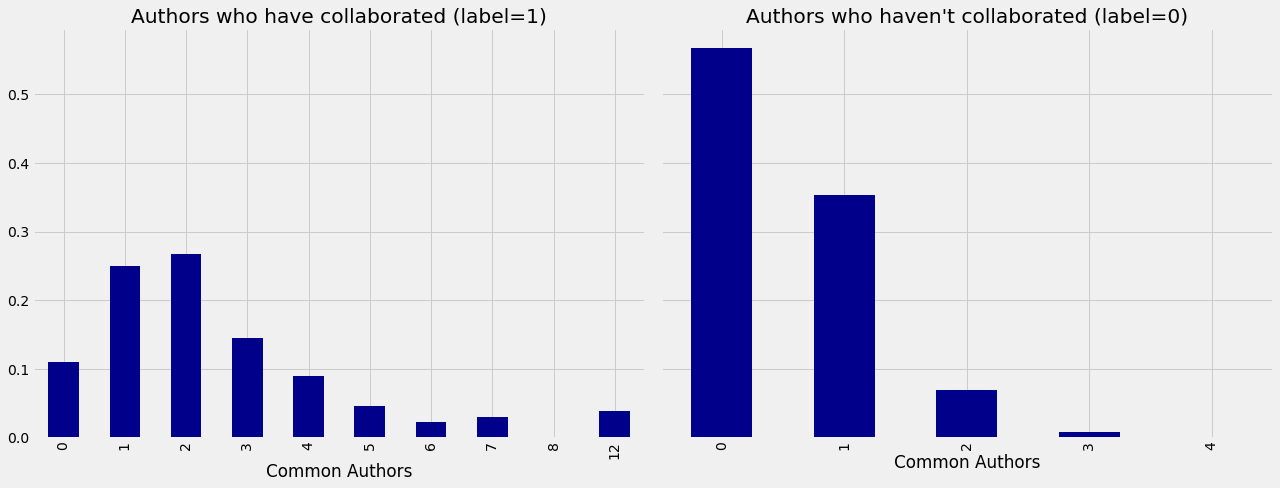

In [35]:
## frequency histogram of common authors
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    common_authors = filtered.toPandas()["commonAuthors"]
    histogram = common_authors.value_counts().sort_index()
    histogram /= float(histogram.sum())
    histogram.plot(kind="bar", x='Common Authors', color="darkblue",
    ax=axs[index], title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Common Authors")
plt.tight_layout()
plt.show()

In [36]:
(training_data.filter(training_data["label"]==1)
    .describe()
    .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
    .show())

+-------+------------------+------------------+-----------------+
|summary|     commonAuthors|    prefAttachment|   totalNeighbors|
+-------+------------------+------------------+-----------------+
|  count|              2400|              2400|             2400|
|   mean|            2.6225|21.468333333333334|5.240833333333334|
| stddev|2.4911669715952036| 33.84827235174229|2.889142424469169|
|    min|                 0|                 1|                2|
|    max|                12|               195|               16|
+-------+------------------+------------------+-----------------+



In [37]:
(training_data.filter(training_data["label"]==0)
    .describe()
    .select("summary", "commonAuthors", "prefAttachment", "totalNeighbors")
    .show())

+-------+------------------+------------------+------------------+
|summary|     commonAuthors|    prefAttachment|    totalNeighbors|
+-------+------------------+------------------+------------------+
|  count|              2400|              2400|              2400|
|   mean|           0.52125|12.422916666666667| 4.498333333333333|
| stddev|0.6712447453264622| 16.96802941816447|2.5734717220483097|
|    min|                 0|                 1|                 1|
|    max|                 4|               225|                18|
+-------+------------------+------------------+------------------+



In [38]:
# Using Neo4j Data Science plug-in to calculate triangles 
# The Triangle Count algorithm in the GDS library only finds triangles in undirected graphs. 

# Create graph projections of early and all colaborations
graphdb.run("""CALL gds.graph.create('early_graph',
    'Author', 
        {
        CO_AUTHOR_EARLY: 
            {
            type: 'CO_AUTHOR_EARLY',
            orientation: 'UNDIRECTED'
            }
        }       
    )""")


In [39]:
# One can estimate the memory needed to run an algorithm
graphdb.run("""CALL gds.triangleCount.write.estimate('early_graph', {
    writeProperty: 'triangles' })
    YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
    """).to_ndarray()  

array([['4097', '4800', '32872', '32872', '32 KiB']], dtype='<U21')

In [40]:
graphdb.run("""CALL gds.triangleCount.write('early_graph', {
    writeProperty: 'triangles'
    })
    YIELD globalTriangleCount, nodeCount""").to_ndarray()


array([[2089, 4097]])

In [41]:
# The clustering coefficient algorithm is actually calculating triangles in background,
# so you can make it use already calculated triangle counts for efficiency 
graphdb.run("""CALL gds.localClusteringCoefficient.write('early_graph', {
      writeProperty: 'localClusteringCoefficient'
    })
    YIELD averageClusteringCoefficient, nodeCount""").to_ndarray()

array([[3.06685223e-01, 4.09700000e+03]])

In [42]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
    AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
    AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
    AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
    AS maxCoefficient
    """
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()],
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = spark.createDataFrame(graphdb.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [43]:
training_data = apply_triangles_features(training_data,
        "triangles", "localClusteringCoefficient")

In [44]:
# create a graph projection
graphdb.run("""CALL gds.graph.create('late_graph',
    'Author', 
    {
        CO_AUTHOR: {
            type: 'CO_AUTHOR',
            orientation: 'UNDIRECTED'
            }
        }
    )""")

In [45]:
graphdb.run("""CALL gds.triangleCount.write('late_graph', {
    writeProperty: 'triangles'
    })
    YIELD globalTriangleCount, nodeCount
    """).to_ndarray()

array([[4910, 4097]])

In [46]:
graphdb.run("""CALL gds.localClusteringCoefficient.write('late_graph', {
      writeProperty: 'localClusteringCoefficient'
    })
    YIELD averageClusteringCoefficient, nodeCount
    """).to_ndarray()

array([[7.2163289e-01, 4.0970000e+03]])

In [47]:
test_data = apply_triangles_features(test_data,
        "triangles", "localClusteringCoefficient")

In [48]:
# Label propagation algorithm
graphdb.run("""CALL gds.labelPropagation.write('early_graph', { writeProperty: 'labelProp' })
    YIELD communityCount, ranIterations, didConverge
    """).to_ndarray()

array([[2838,    3,    1]])

In [49]:
graphdb.run("""CALL gds.labelPropagation.write('late_graph', { writeProperty: 'labelProp' })
    YIELD communityCount, ranIterations, didConverge
    """).to_ndarray()

array([[1230,    4,    1]])

In [50]:
# Louvain algorithm
graphdb.run("""CALL gds.louvain.stream('early_graph',
    {includeIntermediateCommunities:true})
    YIELD nodeId, communityId, intermediateCommunityIds
    WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
    SET node.smallest = smallestCommunity
    """)

In [51]:
graphdb.run("""CALL gds.louvain.stream('late_graph',
    {includeIntermediateCommunities:true})
    YIELD nodeId, communityId, intermediateCommunityIds
    WITH gds.util.asNode(nodeId) AS node, intermediateCommunityIds[0] AS smallestCommunity
    SET node.smallest = smallestCommunity
    """)

In [52]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
    1 ELSE 0 END AS samePartition,
    CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
    1 ELSE 0 END AS sameLouvain
    """
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]} for
    row in data.collect()],
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = spark.createDataFrame(graphdb.run(query, params).to_data_frame())
    return data.join(features, ["node1", "node2"])

In [61]:
training_data = apply_community_features(training_data,"labelProp", "smallest")
test_data = apply_community_features(test_data,"labelProp", "smallest")

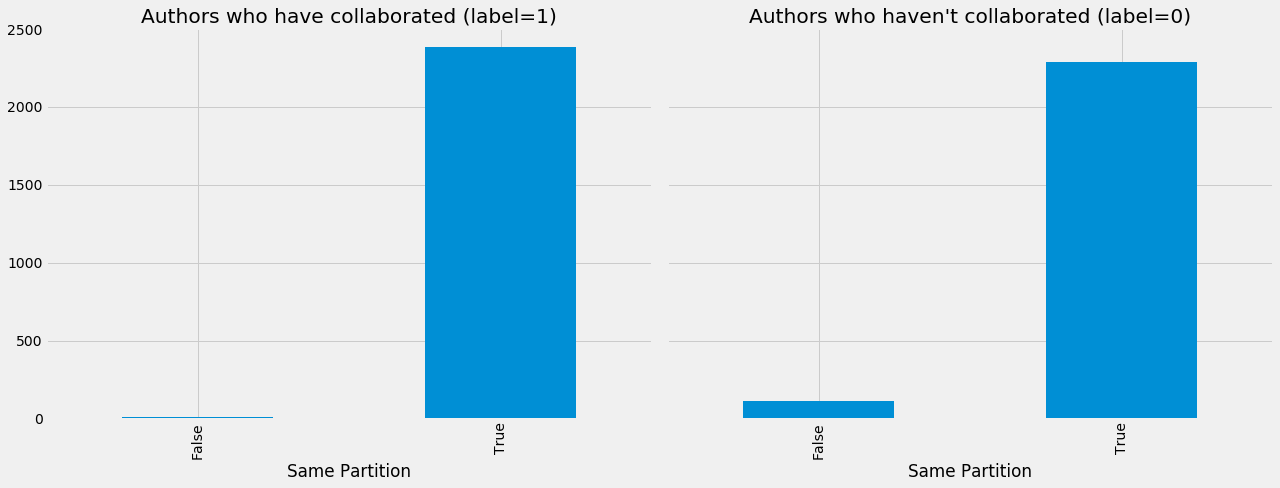

In [62]:
# Number of authors with same labels between authors who collaborated and those who did not

import pyspark.sql.functions as F

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('samePartition',F.when(F.col("samePartition") == 0, "False")
        .otherwise("True"))
        .groupby("samePartition")
        .agg(F.count("label").alias("count"))
        .select("samePartition", "count")
        .toPandas())
    values.set_index("samePartition", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
    title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

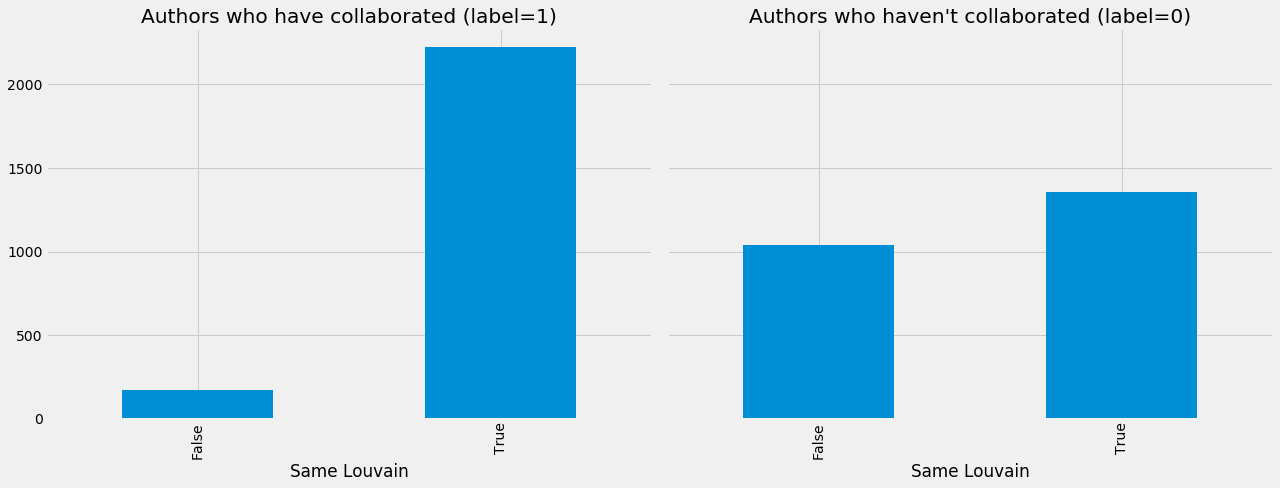

In [63]:
# Comparing number of authors in same louvain community between those who collaborated and those who didn't
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]
for index, chart in enumerate(charts):
    label, title = chart
    filtered = training_data.filter(training_data["label"] == label)
    values = (filtered.withColumn('sameLouvain',
    F.when(F.col("sameLouvain") == 0, "False")
    .otherwise("True"))
    .groupby("sameLouvain")
    .agg(F.count("label").alias("count"))
    .select("sameLouvain", "count")
    .toPandas())
    values.set_index("sameLouvain", drop=True, inplace=True)
    values.plot(kind="bar", ax=axs[index], legend=None,
    title=f"Authors who {title} (label={label})")
    axs[index].xaxis.set_label_text("Same Louvain")

plt.tight_layout()
plt.show()

## <a id="rf">7. Random Forest Classifier </a> 


Using the features built above I train a Random Forest binary classifier to predict whether a pair of authors will have a link or not in the future. I build three different models:

* Model 1: Common Authors + Total Neighbors + Preferential Attachment
* Model 2: Model 1 + Triangle Count + Local Clustering Coefficient
* Model 3: Model 2 + Louvain + Label Propagation

For local development purposes setting number of trees to 30, below the default of 200.

As performance metric the Area Under the Receiver Operating Curve or AUC is is a good way to capture a model's ability to both identify positive examples correctly (Sensitivity) and negavite examples (Specificity).


Here I differ to the book in how I set up the Spark Pipeline to be able to test several different models on the same cross-validation folds.






[Back to top](#top)


In [64]:
from pyspark.ml.feature import RFormula
from pyspark.ml.tuning import ParamGridBuilder

rForm = RFormula()

params = ParamGridBuilder()\
    .addGrid(rForm.formula, [
    "label ~ commonAuthors + prefAttachment + totalNeighbors",
    "label ~ commonAuthors + prefAttachment + totalNeighbors + minTriangles + maxTriangles + minCoefficient + maxCoefficient",
    "label ~ commonAuthors + prefAttachment + totalNeighbors + minTriangles + maxTriangles + minCoefficient + maxCoefficient + samePartition + sameLouvain"])\
    .build()

params


[{Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ commonAuthors + prefAttachment + totalNeighbors'},
 {Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ commonAuthors + prefAttachment + totalNeighbors + minTriangles + maxTriangles + minCoefficient + maxCoefficient'},
 {Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ commonAuthors + prefAttachment + totalNeighbors + minTriangles + maxTriangles + minCoefficient + maxCoefficient + samePartition + sameLouvain'}]

In [65]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

rf = RandomForestClassifier(labelCol="label", 
        featuresCol="features",
        numTrees=30, maxDepth=10)

stages=[rForm, rf]
pipeline=Pipeline().setStages(stages)

In [66]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()\
    .setMetricName("areaUnderROC")\
    .setRawPredictionCol("prediction")\
    .setLabelCol("label")

## <a id="custom-cv">8. Custom Cross-validator </a> 

Using a cross-validator pipeline allows me to run all models at once, instead of each one separately. Spark currently only supports random partition into train and test sets so I use a custom cross-validator in order to be able to define which observations are in train and test set.

Custom cross-validation folds in Spark inspired by https://www.timlrx.com/2018/04/08/creating-a-custom-cross-validation-function-in-pyspark 


[Back to top](#top)


In [67]:
from pyspark import keyword_only
from multiprocessing.pool import ThreadPool
from pyspark.ml.tuning import CrossValidator, _parallelFitTasks, CrossValidatorModel
import numpy as np
from pyspark.sql.functions import rand

class MyCrossValidator(CrossValidator):

    def _fit(self, dataset):
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)
        eva = self.getOrDefault(self.evaluator)
        
        folds = dataset.select('fold').distinct().collect()
        nFolds = len(folds)
        
        metrics = [0.0] * numModels

        pool = ThreadPool(processes=min(self.getParallelism(), numModels))
        subModels = None
        
        allMetrics=[[None for i in range(nFolds)] for j in range(numModels)]
        
        collectSubModelsParam = self.getCollectSubModels()
        if collectSubModelsParam:
            subModels = [[None for j in range(numModels)] for i in range(nFolds)]

        for i in range(nFolds):
           
            validation = dataset.filter((dataset['fold']==i) & (dataset['test']==1)).cache()
            train = dataset.filter((dataset['fold']==i) & (dataset['test']==0)).cache()

            tasks = _parallelFitTasks(est, train, eva, validation, epm, collectSubModelsParam)
            for j, metric, subModel in pool.imap(lambda f: f(), tasks):
            
                allMetrics[j][i] = metric
                
                metrics[j] += (metric / nFolds)
                if collectSubModelsParam:
                    subModels[i][j] = subModel

            validation.unpersist()
            train.unpersist()

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)
        bestModel = est.fit(dataset, epm[bestIndex])
        

        return (self._copyValues(CrossValidatorModel(bestModel, metrics, subModels)), allMetrics)



In [68]:
from pyspark.sql.functions import lit

training_data=training_data.withColumn("fold",lit(0))
training_data=training_data.withColumn("test",lit(0))

test_data=test_data.withColumn("fold",lit(0))
test_data=test_data.withColumn("test",lit(1))

In [69]:
all_df=training_data.union(test_data)

In [70]:
all_df.show(n=1)

+-----+-----+-----+-------------+--------------+--------------+------------+------------+-------------------+--------------+-------------+-----------+----+----+
|node1|node2|label|commonAuthors|prefAttachment|totalNeighbors|minTriangles|maxTriangles|     minCoefficient|maxCoefficient|samePartition|sameLouvain|fold|test|
+-----+-----+-----+-------------+--------------+--------------+------------+------------+-------------------+--------------+-------------+-----------+----+----+
|   22|   25|    1|            3|            32|             9|           6|          12|0.42857142857142855|           1.0|            1|          1|   0|   0|
+-----+-----+-----+-------------+--------------+--------------+------------+------------+-------------------+--------------+-------------+-----------+----+----+
only showing top 1 row



In [71]:
import mycrossvalidator as mycv
from importlib import reload  
reload(mycv)

<module 'mycrossvalidator' from '/home/areias/Documents/DataScience/graphs/mycrossvalidator.py'>

In [72]:
import mycrossvalidator as mycv

cv = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params)\
    .setCollectSubModels(True)


In [73]:
mycvfitted, foldstats = cv.fit(all_df)

In [74]:
# save models
mycvfitted.subModels[0][0].save("/home/areias/Documents/DataScience/graphs/results/graphy_model")
mycvfitted.subModels[0][1].save("/home/areias/Documents/DataScience/graphs/results/triangle_model")
mycvfitted.subModels[0][2].save("/home/areias/Documents/DataScience/graphs/results/community_model")

In [75]:
import pickle
filename="/home/areias/Documents/DataScience/graphs/results/model_community.pkl"
with open(filename, 'wb') as f:
    pickle.dump(mycvfitted.avgMetrics, f)

## <a id="model-comparison">9. Model Comparison </a> 


All three models, each with an increasing number of graph features, perform very well with an AUC above 0.90. The Random Forest importance metrics shows that by far the most predictive feature is common authors.


ROC curve from https://stackoverflow.com/questions/54425084/pyspark-get-threshold-cuttoff-values-for-each-point-in-roc-curve



[Back to top](#top)

In [76]:
from sklearn.metrics import roc_curve

def get_roc_curve(model,test_data):
    
    predictions=model.transform(test_data)
    
    preds = predictions.select('label','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))\
    .collect()
     
    y_score, y_true = zip(*preds)
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label = 1)
    
    return fpr,tpr,thresholds

In [77]:
# get ROC AUC values for each model tested
fpr0,tpr0,thresholds1 = get_roc_curve(mycvfitted.subModels[0][0], test_data)
fpr1,tpr1,thresholds2 = get_roc_curve(mycvfitted.subModels[0][1], test_data)
fpr2,tpr2,thresholds3 = get_roc_curve(mycvfitted.subModels[0][2], test_data)

In [78]:
from cycler import cycler
def create_roc_plot():
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(8, 6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rc('axes', prop_cycle=(cycler('color',
    ['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random score (AUC = 0.50)')
    return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")
    

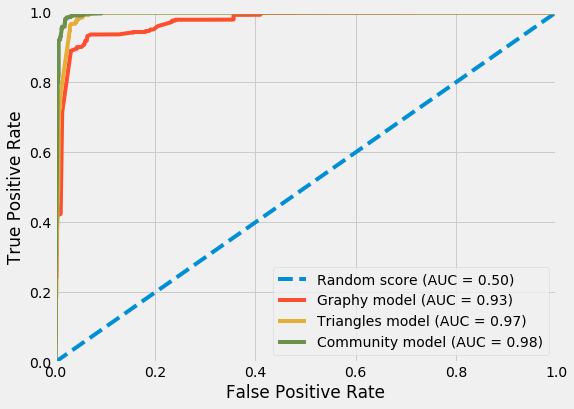

In [79]:
plt,fig = create_roc_plot()

add_curve(plt, "Graphy model",
    fpr0, tpr0,
    mycvfitted.avgMetrics[0])

add_curve(plt, "Triangles model",
    fpr1, tpr1,
    mycvfitted.avgMetrics[1])

add_curve(plt, "Community model",
    fpr2, tpr2,
    mycvfitted.avgMetrics[2])

plt.legend(loc='lower right')
plt.show()

In [86]:
import pandas as pd
def plot_feature_importance(fields, feature_importances, title):
    df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None, figsize=(8,6))
    ax.xaxis.set_label_text("")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [87]:
fields=["commonAuthors", "prefAttachment", "totalNeighbors", "minTriangles", "maxTriangles", 
    "minCoefficient", "maxCoefficient", "samePartition", "sameLouvain"]

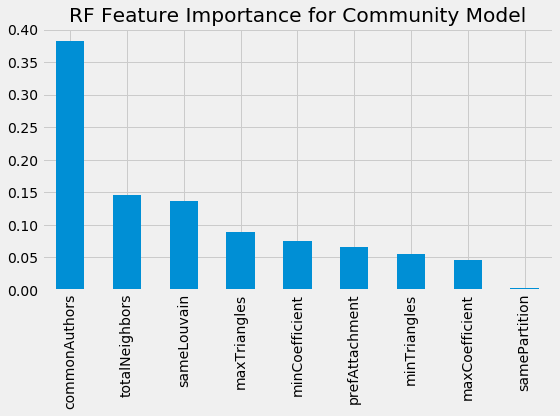

In [88]:
plt.style.use("fivethirtyeight")
plot_feature_importance(fields, mycvfitted.subModels[0][2].stages[1].featureImportances, 
                        "RF Feature Importance for Community Model")

## <a id="node2vec">10. Node2Vec Embeddings </a> 


There is an alpha implementation of node2vec in Neo4j. Alpha designation indicates that the algorithm is experimental and might be changed or removed at any time. https://neo4j.com/docs/graph-data-science/current/algorithms/node-embeddings/

Neo4j Graph Data Science library supports the random walk algorithm, it has the following parameters:

* Number of walks: Number of random walks to be generated from each node in the graph
* Walk length: How many nodes are in each random walk
* P: Return hyperparameter
* Q: Inout hyperaprameter

I use the Word2vec algorithm implementation in the Gensim library. It also has a couple of hyperparameters we can define. Most notable are:

* dimensions - Dimensionality of node2vec embeddings
* window_size - Context window size for Word2Vec

I perform three experiments to examine how the different choices of parameters affect the performance of node2vec:

1. Choice of Binary operator: This defines how one chooses to combine the embeddings of each node in order to represent an edge. The options are average, hadamard, l1 and l2 operators.

2. In-Out and Return Parameters: I perform a grid search over p,q ∈{0.25,0.50,1,2,4}.

3. I also examine how the number of features and the node's neighborhood parameters (dimension, number of walks, walk length, and neighborhood size) affect the performance. Except for the parameter being tested, all other parameters assume default values. The default values for p and q are set to unity.  
   dimensions default=128  
   num_walks default=10  
   walk_length default=80  
   window_size  default=10  
   
   
Node2Vec implementation using Neo4j Random Walk algorithm and Gensim's word2vec library based on https://towardsdatascience.com/node-embeddings-node2vec-with-neo4j-5152d3472d8e
   
Node2Vec algorithm parameter tuning based on https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf 

Binary operators definitions from https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html


[Back to top](#top)

### <a id="exp1">Experiment 1: Choice of binary operator </a> 

In this example, the L1 and L2 operators perform better than average and Hadamard. The node2vec KDD paper found Hadamard to be most stable, which also points to the necessity of performing more than one train/test split to assess performance variability.

In [90]:
# this could be rewritten to take in the function as an argument (in a functional manner!)
def binary_operator(name,u,v):
    
    def operator_hadamard(u, v):
        return u * v

    def operator_l1(u, v):
        return np.abs(u - v)

    def operator_l2(u, v):
        return (u - v) ** 2

    def operator_avg(u, v):
        return (u + v) / 2.0

    if name=="hadamard":
        return operator_hadamard(u,v)
    elif name=="l1":
        return operator_l1(u,v)
    elif name=="average":
        return operator_avg(u,v)
    elif name=="l2":
        return operator_l2(u,v)
    

In [91]:
import gensim.models
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import StructField, StructType,IntegerType

def apply_node2vec_features(data, graph_name, walk_length, num_walks, dimensions, 
                            window_size, p, q, num_iter, workers, operator_name,
                            output_col_name):
    
    params = {
    "pairs": [{"node1": row["node1"], "node2": row["node2"]}
    for row in data.collect()],
    "steps": walk_length,
    "walks": num_walks,
    "size": dimensions,
    "graph_name": graph_name,
    "mode":"node2vec",
    "inOut":q,
    "return":p
    }

    query=("""
    UNWIND $pairs as pair
    MATCH (p:Author) WHERE id(p) = pair.node1 OR id(p) = pair.node2
    WITH DISTINCT p
    CALL gds.alpha.randomWalk.stream($graph_name,{
        start: id(p),
        steps: $steps,
        walks: $walks,
        mode: $mode,
        inOut: $inOut,
        return: $return  
    })
    YIELD nodeIds
    RETURN [id in nodeIds | toString(id)] as walks
    """)

    random_walks=graphdb.run(query, params).to_series()
    
    model=gensim.models.Word2Vec(random_walks, sg=1, window=window_size, size=dimensions, min_count=1,
                                 workers=workers,iter=num_iter)

    vectors=[{"node1":row["node1"],
            "node2": row["node2"],
            output_col_name: Vectors.dense(
                binary_operator(operator_name, model.wv[str(row["node1"])], model.wv[str(row["node2"])]))
            } for row in data.collect()]
    
    schema = StructType([
        StructField('node1', IntegerType()),
        StructField('node2', IntegerType()),
        StructField(output_col_name, VectorUDT())])

    features=spark.createDataFrame(vectors, schema)
    return data.join(features, ["node1", "node2"])



In [92]:
# default params
dimensions = 128
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = 2
p=1
q=1

In [93]:
training_data=spark.createDataFrame(training_df)
test_data=spark.createDataFrame(test_df)

In [94]:
operators=['average', 'hadamard', 'l1', 'l2']

In [95]:
import numpy as np
for item in enumerate(operators):
    model_name="model"+str(item[0])
    training_data = apply_node2vec_features(training_data, 'early_graph', walk_length, num_walks, dimensions, 
                            window_size, p, q, num_iter, workers, item[1],
                            model_name)
    test_data = apply_node2vec_features(test_data, 'late_graph', walk_length, num_walks, dimensions, 
                            window_size, p, q, num_iter, workers, item[1],
                            model_name)

In [96]:
params = ParamGridBuilder()\
    .addGrid(rForm.formula, ["label ~ model"+str(i) for i in range(4)])\
    .build()
params

[{Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ model0'},
 {Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ model1'},
 {Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ model2'},
 {Param(parent='RFormula_ec777b8d4804', name='formula', doc='R model formula'): 'label ~ model3'}]

In [97]:
training_data=training_data.withColumn("fold",lit(0))
training_data=training_data.withColumn("test",lit(0))

test_data=test_data.withColumn("fold",lit(0))
test_data=test_data.withColumn("test",lit(1))

In [98]:
all_df=training_data.union(test_data)

In [99]:
cv = mycv.MyCrossValidator(parallelism=2)\
    .setEstimator(pipeline)\
    .setEvaluator(evaluator)\
    .setEstimatorParamMaps(params)\
    .setCollectSubModels(True)

In [100]:
mycvfitted, foldstats = cv.fit(all_df)

In [101]:
# save models
mycvfitted.subModels[0][0].save("/home/areias/Documents/DataScience/graphs/results/average_model")
mycvfitted.subModels[0][1].save("/home/areias/Documents/DataScience/graphs/results/hadamard_model")
mycvfitted.subModels[0][2].save("/home/areias/Documents/DataScience/graphs/results/l1_model")
mycvfitted.subModels[0][3].save("/home/areias/Documents/DataScience/graphs/results/l2_model")

In [102]:
filename="/home/areias/Documents/DataScience/graphs/results/model_operators.pkl"
with open(filename, 'wb') as f:
    pickle.dump(mycvfitted.avgMetrics, f)

In [103]:
fpr3,tpr3,thresholds3 = get_roc_curve(mycvfitted.subModels[0][0], test_data)
fpr4,tpr4,thresholds4 = get_roc_curve(mycvfitted.subModels[0][1], test_data)
fpr5,tpr5,thresholds5 = get_roc_curve(mycvfitted.subModels[0][2], test_data)
fpr6,tpr6,thresholds6 = get_roc_curve(mycvfitted.subModels[0][3], test_data)

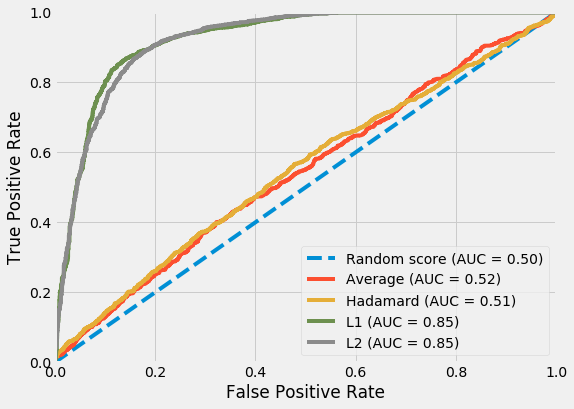

In [104]:
plt,fig = create_roc_plot()

add_curve(plt, "Average",
    fpr3, tpr3,
    mycvfitted.avgMetrics[0])

add_curve(plt, "Hadamard",
    fpr4, tpr4,
    mycvfitted.avgMetrics[1])

add_curve(plt, "L1",
    fpr5, tpr5,
    mycvfitted.avgMetrics[2])

add_curve(plt, "L2",
    fpr6, tpr6,
    mycvfitted.avgMetrics[3])

plt.legend(loc='lower right')
plt.show()

### <a id="exp2">Experiment 2: In-Out and Return Parameters </a> 

A grid search through p and q values shows that their choice is an important determinant of performance, resulting in AUC values from 0.74 to 0.90. A smaller  p and larger q are optimal, this follows the node2vec KDD paper. 



The rest of the experiments follow similar pattern but were done through spark-submit scripts. Here I just show the results.

/opt/spark-2.4.3/bin/spark-submit \
  --master local[*] \
  /home/areias/Documents/DataScience/graphs/coauthor-link-prediction-benchmark.py 


In [105]:
# 25 different models
from sklearn.model_selection import ParameterGrid
grid = [{'p': [0.25,0.5,1,2,4],'q': [0.25,0.5,1,2,4]}]
list(ParameterGrid(grid))

[{'p': 0.25, 'q': 0.25},
 {'p': 0.25, 'q': 0.5},
 {'p': 0.25, 'q': 1},
 {'p': 0.25, 'q': 2},
 {'p': 0.25, 'q': 4},
 {'p': 0.5, 'q': 0.25},
 {'p': 0.5, 'q': 0.5},
 {'p': 0.5, 'q': 1},
 {'p': 0.5, 'q': 2},
 {'p': 0.5, 'q': 4},
 {'p': 1, 'q': 0.25},
 {'p': 1, 'q': 0.5},
 {'p': 1, 'q': 1},
 {'p': 1, 'q': 2},
 {'p': 1, 'q': 4},
 {'p': 2, 'q': 0.25},
 {'p': 2, 'q': 0.5},
 {'p': 2, 'q': 1},
 {'p': 2, 'q': 2},
 {'p': 2, 'q': 4},
 {'p': 4, 'q': 0.25},
 {'p': 4, 'q': 0.5},
 {'p': 4, 'q': 1},
 {'p': 4, 'q': 2},
 {'p': 4, 'q': 4}]

In [117]:
## P and Q
from collections import defaultdict
pq_results=defaultdict(list)

for q in [0.25, 0.50, 1,2,4]:
    with open("/home/areias/Documents/DataScience/graphs/results/model_q"+str(q).replace(".","")+".pkl",'rb') as f:
            pq_results[q]=pickle.load(f)

In [119]:
df=pd.DataFrame.from_dict(pq_results,orient='index',
                         columns=['0.25', '0.50', '1', '2','4'])
df['q']=df.index
df=pd.melt(df,'q')
df.columns=['q','p','auc']
df.set_index('q', inplace=True)

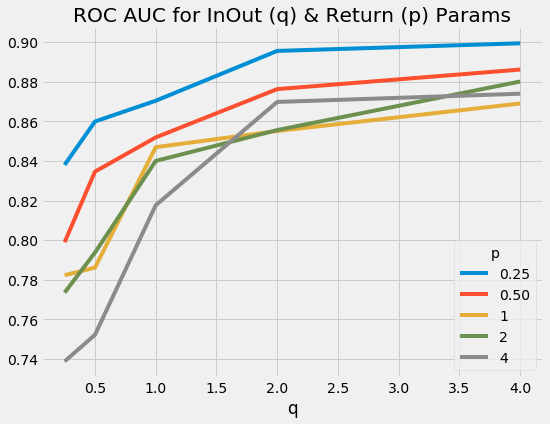

In [121]:
plt.style.use('fivethirtyeight')
df.groupby('p')['auc'].plot(legend=True, figsize=(8,6))
plt.legend(title="p", loc='lower right')
plt.title("ROC AUC for InOut (q) & Return (p) Params")
plt.show()

### <a id="exp3">Experiment 3: Walk length, number of walks, window size and dimensions </a> 

These parameters are also shown to affect performance, but to a lesser extent than p and q levels. Priority should be given to tuning p and q while the default values could be used for the rest. 

In [123]:
dimensions=[ i * i for i in range(4,9)]+[128]
walks=list(range(6,22,2))
walk_length=list(range(40,110,10))
window_size=list(range(8,22,2))

In [124]:
with open("/home/areias/Documents/DataScience/graphs/results/model_dimensions.pkl",'rb') as f:
            dimension_results=pickle.load(f)
with open("/home/areias/Documents/DataScience/graphs/results/model_q1.pkl",'rb') as f:
            other=pickle.load(f)        
dimension_results=dimension_results+[other[2]]

In [125]:
walk_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/results/model_walks"+part+".pkl",'rb') as f:
            walk_results=walk_results+(pickle.load(f))

In [126]:
length_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/results/model_length"+part+".pkl",'rb') as f:
            length_results=length_results+(pickle.load(f))

In [127]:
window_results=[]
for part in ['part1','part2']:
    with open("/home/areias/Documents/DataScience/graphs/results/model_window"+part+".pkl",'rb') as f:
            window_results=window_results+(pickle.load(f))

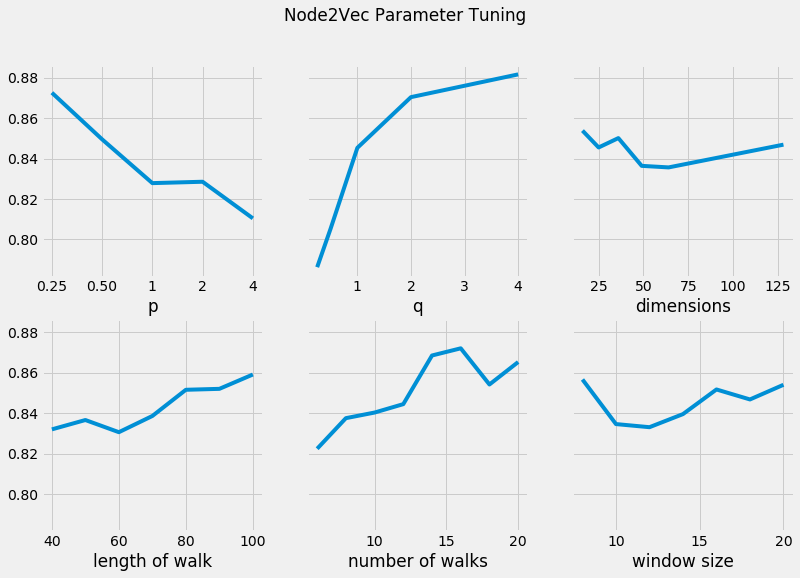

In [129]:
plt.style.use('fivethirtyeight')

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, sharey=True,figsize=(12,8))
fig.suptitle('Node2Vec Parameter Tuning')

ax1.plot(df.groupby('p')['auc'].mean())
ax1.set_xlabel("p")

ax2.plot(df.groupby('q')['auc'].mean())
ax2.set_xlabel("q")

ax3.plot(dimensions, dimension_results)
ax3.set_xlabel("dimensions")

ax4.plot(walk_length, length_results)
ax4.set_xlabel("length of walk")

ax5.plot(walks, walk_results)
ax5.set_xlabel("number of walks")

ax6.plot(window_size, window_results)
ax6.set_xlabel("window size")

plt.show()

## <a id="comparison2">11. Model comparison once more </a> 

While tuning node2vec parameters increases AUC from 0.85 to 0.91, it is less than the 0.98 AUC of the classifier that includes neighborhood, graph and community features.

[Back to top](#top)



In [132]:
p=0.25
q=4
dimensions=16
num_walks=16
walk_length=100
window_size=8
operator_name="l1"

In [133]:
from pyspark.ml import PipelineModel

In [134]:
bestModel=PipelineModel.load("/home/areias/Documents/DataScience/graphs/results/model_best_submodel/")

In [135]:
with open("/home/areias/Documents/DataScience/graphs/results/model_best.pkl",'rb') as f:
            bestModel.avgMetrics=pickle.load(f)

In [136]:
test_data = apply_node2vec_features(test_data, 'late_graph', walk_length, num_walks, dimensions, 
                            window_size, p, q, num_iter, workers, operator_name,
                            "best")

In [137]:
fpr7,tpr7,thresholds7 = get_roc_curve(bestModel, test_data)

In [141]:
with open("/home/areias/Documents/DataScience/graphs/results/model_community.pkl",'rb') as f:
    community=pickle.load(f)
        

In [143]:
with open("/home/areias/Documents/DataScience/graphs/results/model_operators.pkl",'rb') as f:
    operator=pickle.load(f)

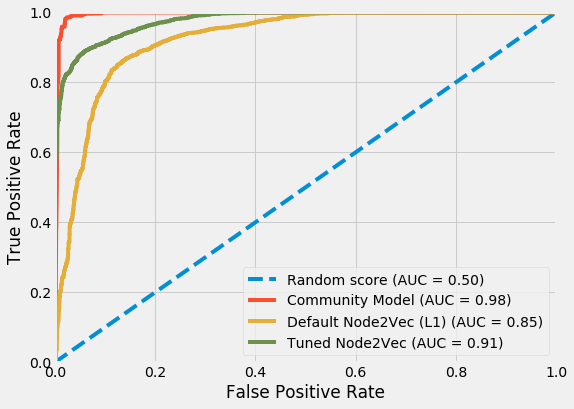

In [145]:
plt,fig = create_roc_plot()

add_curve(plt, "Community Model",
    fpr2, tpr2,
    community[2])

add_curve(plt, "Default Node2Vec (L1)",
    fpr5, tpr5,
    operator[2])

add_curve(plt, "Tuned Node2Vec",
    fpr7, tpr7,
    bestModel.avgMetrics[0])

plt.legend(loc='lower right')
plt.show()

## <a id="conclusions">12. Conclusions and future steps </a>

Using only on train/test split doesn't allow us to have a sense of the variability in classifier performance. It is possible that a different sample of the data results in different classifier rankings. So first thing to add in a second iteration would be repeated test/train samples. 

Also the Neo4j Data Science plugin has a node2vec implementation so it wasn't really necessary to bring an outside node2vec library, but instructive nonetheless.


[Back to top](#top)


## <a id="references">13. References </a>

Neo4j cypher queries for creating co-authorship graph, data balancing and graphy features are from book chapter "Graphs and Machine Learning in Practice: Link Prediction" in *Graph Algorithms. Practical Examples in Apache Spark and Neo4j.*

Node2Vec implementation using Neo4j Random Walk algorithm and Gensim's word2vec library based on https://towardsdatascience.com/node-embeddings-node2vec-with-neo4j-5152d3472d8e

Node2Vec algorithm parameter tuning based on https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf 

Binary operators definitions from https://stellargraph.readthedocs.io/en/stable/demos/link-prediction/node2vec-link-prediction.html

Custom cross-validation folds in Spark inspired by https://www.timlrx.com/2018/04/08/creating-a-custom-cross-validation-function-in-pyspark 


ROC curve from https://stackoverflow.com/questions/54425084/pyspark-get-threshold-cuttoff-values-for-each-point-in-roc-curve


[Back to top](#top)